# Store Sales of Corporation Favorita

## Business Analysis

#### This project revolves around time series forecasting with the objective of predicting store sales using data from Corporation Favorita, a prominent grocery retailer based in Ecuador. The primary goal is to develop a model that enhances the accuracy of predicting unit sales for a myriad of items sold across various Favorita stores.







## Understanding the data

The training data includes dates, store, and product information, whether that item was being promoted, as well as the sales numbers. Additional files include supplementary information that may be useful in building your models

File Descriptions and Data Field Information

train.csv

The training data, comprising time series of features store_nbr, family, and onpromotion as well as the target sales.

store_nbr identifies the store at which the products are sold.

family identifies the type of product sold.

sales gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).

onpromotion gives the total number of items in a product family that were being promoted at a store at a given date.

test.csv

The test data, having the same features as the training data. You will predict the target sales for the dates in this file.

The dates in the test data are for the 15 days after the last date in the training data.

transaction.csv

Contains date, store_nbr and transaction made on that specific date.
sample_submission.csv

A sample submission file in the correct format.
stores.csv

Store metadata, including city, state, type, and cluster.

cluster is a grouping of similar stores.

oil.csv

Daily oil price which includes values during both the train and test data timeframes. (Ecuador is an oil-dependent country and its economical health is highly vulnerable to shocks in oil prices.)
holidays_events.csv

Holidays and Events, with metadata

## Hypothesis

#### Null hypothesis: Promotion do increases/affects sales
#### Alternate hypothesis: Promotions increase/affect sales

## Analytical Questions
#### 1. Is the train data set complete?
#### 2. Which dates have the lowest and highest sales for each year?
#### 3. Are certain groups of stores selling more products? Cluster, City, State ,Type
#### 4. Are sales affected by promotions, oil prices and holidays?

## Issues with the data

Inconsistency

### Import libraries

In [179]:
import numpy as np
import pandas as pd
import seaborn as sns 
import pyodbc
import matplotlib.pyplot as plt
from datetime import datetime 
import plotly.express as px
from sklearn.preprocessing import StandardScaler, OneHotEncoder
#statistical analysis
from statsmodels.tsa.stattools import adfuller
from scipy.stats import ttest_ind
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error


#feature processing 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

#modelling 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import RandomizedSearchCV
import pickle

import warnings

warnings.filterwarnings("ignore")
 

## Load datasets

In [180]:
# Load environment variables from .env file into a dictionary
from dotenv import  dotenv_values
environment_variables = dotenv_values('.env')
 
# Get the values for the credentials you set in the '.env' file
server = environment_variables.get("SERVER")
database = environment_variables.get("DATABASE")
username = environment_variables.get("USER")
password = environment_variables.get("PASSWORD")
 

connection_string = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password};MARS_Connection=yes;MinProtocolVersion=TLSv1.2;"
 

In [181]:
print(connection_string)

DRIVER={SQL Server};SERVER=dap-projects-database.database.windows.net;DATABASE=dapDB;UID=learning_project_3;PWD=A$uB1Lp3$2@24;MARS_Connection=yes;MinProtocolVersion=TLSv1.2;


In [182]:
connection = pyodbc.connect(connection_string)

In [183]:
query='SELECT * from dbo.oil'

df_oil=pd.read_sql(query, connection)

#df_oil.head()

In [184]:
df_oil.isnull().sum()

date           0
dcoilwtico    43
dtype: int64

In [185]:

# Fill missing values in the 'dcoilwtico' column using backfill strategy

df_oil['dcoilwtico'] = df_oil['dcoilwtico'].fillna(method='backfill')


In [186]:
df_oil.isnull().sum()

date          0
dcoilwtico    0
dtype: int64

In [187]:
df_oil.shape

(1218, 2)

In [188]:
df_oil.describe()

,dcoilwtico
count,1218.000000
mean,67.673325
std,25.637345
min,26.190001
25%,46.422500
50%,53.184999
75%,95.595001
max,110.620003


In [189]:
query_2='SELECT * from dbo.holidays_events'
df_holidays_events=pd.read_sql(query_2, connection)
df_holidays_events.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [190]:
df_holidays_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB


In [191]:
df_holidays_events.isnull().sum()

date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

In [192]:
df_holidays_events.shape

(350, 6)

In [193]:
df_holidays_events.describe()

,date,type,locale,locale_name,description,transferred
count,350,350,350,350,350,350
unique,312,6,3,24,103,2
top,2014-06-25,Holiday,National,Ecuador,Carnaval,False
freq,4,221,174,174,10,338


In [194]:
query_3 ='SELECT * from dbo.stores'
df_stores=pd.read_sql(query_3, connection)
df_stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [195]:
df_stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


In [196]:
df_stores.isnull().sum()

store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

In [197]:
df_stores.shape

(54, 5)

In [198]:
df_stores.describe()

,store_nbr,cluster
count,54.000000,54.000000
mean,27.500000,8.481481
std,15.732133,4.693395
min,1.000000,1.000000
25%,14.250000,4.000000
50%,27.500000,8.500000
75%,40.750000,13.000000
max,54.000000,17.000000


In [199]:
dt=pd.read_csv('train.csv')
dt.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,1/1/2013,1,AUTOMOTIVE,0.0,0
1,1,1/1/2013,1,BABY CARE,0.0,0
2,2,1/1/2013,1,BEAUTY,0.0,0
3,3,1/1/2013,1,BEVERAGES,0.0,0
4,4,1/1/2013,1,BOOKS,0.0,0


In [200]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 6 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   id           1048575 non-null  int64  
 1   date         1048575 non-null  object 
 2   store_nbr    1048575 non-null  int64  
 3   family       1048575 non-null  object 
 4   sales        1048575 non-null  float64
 5   onpromotion  1048575 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 48.0+ MB


In [201]:
dt.isnull().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [202]:
dt.shape

(1048575, 6)

In [203]:
dt.describe()

,id,store_nbr,sales,onpromotion
count,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06
mean,5.242870e+05,2.749256e+01,2.445326e+02,1.147634e-01
std,3.026977e+05,1.558408e+01,8.065892e+02,2.377814e+00
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,2.621435e+05,1.400000e+01,0.000000e+00,0.000000e+00
50%,5.242870e+05,2.700000e+01,1.000000e+00,0.000000e+00
75%,7.864305e+05,4.100000e+01,1.200000e+02,0.000000e+00
max,1.048574e+06,5.400000e+01,4.627100e+04,1.960000e+02


In [204]:
dt2=pd.read_csv('transactions.csv')
dt2.head()

,date,store_nbr,transactions
0,1/1/2013,25,770
1,1/2/2013,1,2111
2,1/2/2013,2,2358
3,1/2/2013,3,3487
4,1/2/2013,4,1922


In [205]:
dt2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          83488 non-null  object
 1   store_nbr     83488 non-null  int64 
 2   transactions  83488 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.9+ MB


In [206]:
dt2.isnull().sum()

date            0
store_nbr       0
transactions    0
dtype: int64

In [207]:
dt2.shape

(83488, 3)

In [208]:
dt2.describe()

,store_nbr,transactions
count,83488.000000,83488.000000
mean,26.939237,1694.602158
std,15.608204,963.286644
min,1.000000,5.000000
25%,13.000000,1046.000000
50%,27.000000,1393.000000
75%,40.000000,2079.000000
max,54.000000,8359.000000


In [209]:
dt3=pd.read_csv('sample_submission.csv')
dt3.head()

,id,sales
0,3000888,0.0
1,3000889,0.0
2,3000890,0.0
3,3000891,0.0
4,3000892,0.0


In [210]:
dt3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      28512 non-null  int64  
 1   sales   28512 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 445.6 KB


In [211]:
dt3.isnull().sum()

id       0
sales    0
dtype: int64

In [212]:
dt3.shape

(28512, 2)

In [213]:
dt3.describe()

,id,sales
count,2.851200e+04,28512.0
mean,3.015144e+06,0.0
std,8.230850e+03,0.0
min,3.000888e+06,0.0
25%,3.008016e+06,0.0
50%,3.015144e+06,0.0
75%,3.022271e+06,0.0
max,3.029399e+06,0.0


In [214]:
dt_test=pd.read_csv('test.csv')
dt_test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [215]:
dt_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           28512 non-null  int64 
 1   date         28512 non-null  object
 2   store_nbr    28512 non-null  int64 
 3   family       28512 non-null  object
 4   onpromotion  28512 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.1+ MB


In [216]:
dt_test.isnull().sum()

id             0
date           0
store_nbr      0
family         0
onpromotion    0
dtype: int64

In [217]:
dt_test.shape

(28512, 5)

In [218]:
dt_test.describe()

,id,store_nbr,onpromotion
count,2.851200e+04,28512.000000,28512.000000
mean,3.015144e+06,27.500000,6.965383
std,8.230850e+03,15.586057,20.683952
min,3.000888e+06,1.000000,0.000000
25%,3.008016e+06,14.000000,0.000000
50%,3.015144e+06,27.500000,0.000000
75%,3.022271e+06,41.000000,6.000000
max,3.029399e+06,54.000000,646.000000


In [219]:
df_oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1218 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB


# EDA ANALYSIS

In [220]:
# Convert 'date' column to datetime format for train data 
dt['date'] = pd.to_datetime(dt['date'], format='%m/%d/%Y').dt.strftime('%Y-%m-%d')
dt.head()


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [221]:

# Converting the 'date' column in the datasets to datetime format
# Train dataset
dt['date'] = pd.to_datetime(dt['date'])
 
# Test dataset
dt_test['date'] = pd.to_datetime(dt_test['date'])
 
# Holiday Events dataset
df_holidays_events['date'] = pd.to_datetime(df_holidays_events['date'])
 
# Oil dataset
df_oil['date'] = pd.to_datetime(df_oil['date'])
 
# Transactions dataset
dt2['date'] = pd.to_datetime(dt2['date'])

In [222]:
df_oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1218 non-null   datetime64[ns]
 1   dcoilwtico  1218 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.2 KB


In [223]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 6 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   id           1048575 non-null  int64         
 1   date         1048575 non-null  datetime64[ns]
 2   store_nbr    1048575 non-null  int64         
 3   family       1048575 non-null  object        
 4   sales        1048575 non-null  float64       
 5   onpromotion  1048575 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 48.0+ MB


In [224]:

# Merging the common columns ('store_nbr' and 'date') in the datasets using the inner merge() function

# Merge train_data with stores_df based on 'store_nbr' column

merged_df1 = dt.merge(df_stores, on='store_nbr', how='inner')
 
# Merge merged_df1 with trans_data based on 'date' and 'store_nbr' columns

merged_df2 = merged_df1.merge(dt2, on=['date', 'store_nbr'], how='inner')
 
# Merge merged_df2 with holidays_events_df based on 'date' column

merged_df3 = merged_df2.merge(df_holidays_events, on='date', how='inner')
 
# Merge merged_df3 with oil_df based on 'date' column

merged_data = merged_df3.merge(df_oil, on='date', how='inner')
 
# View the first five rows of the merged dataset

merged_data.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,transactions,type_y,locale,locale_name,description,transferred,dcoilwtico
0,561,2013-01-01,25,AUTOMOTIVE,0.0,0,Salinas,Santa Elena,D,1,770,Holiday,National,Ecuador,Primer dia del ano,False,93.139999
1,562,2013-01-01,25,BABY CARE,0.0,0,Salinas,Santa Elena,D,1,770,Holiday,National,Ecuador,Primer dia del ano,False,93.139999
2,563,2013-01-01,25,BEAUTY,2.0,0,Salinas,Santa Elena,D,1,770,Holiday,National,Ecuador,Primer dia del ano,False,93.139999
3,564,2013-01-01,25,BEVERAGES,810.0,0,Salinas,Santa Elena,D,1,770,Holiday,National,Ecuador,Primer dia del ano,False,93.139999
4,565,2013-01-01,25,BOOKS,0.0,0,Salinas,Santa Elena,D,1,770,Holiday,National,Ecuador,Primer dia del ano,False,93.139999


In [225]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86559 entries, 0 to 86558
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            86559 non-null  int64         
 1   date          86559 non-null  datetime64[ns]
 2   store_nbr     86559 non-null  int64         
 3   family        86559 non-null  object        
 4   sales         86559 non-null  float64       
 5   onpromotion   86559 non-null  int64         
 6   city          86559 non-null  object        
 7   state         86559 non-null  object        
 8   type_x        86559 non-null  object        
 9   cluster       86559 non-null  int64         
 10  transactions  86559 non-null  int64         
 11  type_y        86559 non-null  object        
 12  locale        86559 non-null  object        
 13  locale_name   86559 non-null  object        
 14  description   86559 non-null  object        
 15  transferred   86559 non-null  bool  

In [226]:
# Check the unique values of the two unknown columns
print("Unique values of 'type_x':")
print(merged_data['type_x'].unique())
print()
print("Unique values of 'type_y':")
print(merged_data['type_y'].unique())

Unique values of 'type_x':
['D' 'C' 'B' 'E' 'A']

Unique values of 'type_y':
['Holiday' 'Additional' 'Transfer' 'Event']


In [227]:
# Renaming the columns with the approapriate names
merged_data = merged_data.rename(columns={"type_x": "store_type", "type_y": "holiday_type"})
merged_data.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,transactions,holiday_type,locale,locale_name,description,transferred,dcoilwtico
0,561,2013-01-01,25,AUTOMOTIVE,0.0,0,Salinas,Santa Elena,D,1,770,Holiday,National,Ecuador,Primer dia del ano,False,93.139999
1,562,2013-01-01,25,BABY CARE,0.0,0,Salinas,Santa Elena,D,1,770,Holiday,National,Ecuador,Primer dia del ano,False,93.139999
2,563,2013-01-01,25,BEAUTY,2.0,0,Salinas,Santa Elena,D,1,770,Holiday,National,Ecuador,Primer dia del ano,False,93.139999
3,564,2013-01-01,25,BEVERAGES,810.0,0,Salinas,Santa Elena,D,1,770,Holiday,National,Ecuador,Primer dia del ano,False,93.139999
4,565,2013-01-01,25,BOOKS,0.0,0,Salinas,Santa Elena,D,1,770,Holiday,National,Ecuador,Primer dia del ano,False,93.139999


In [228]:
merged_data.shape

(86559, 17)

In [229]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86559 entries, 0 to 86558
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            86559 non-null  int64         
 1   date          86559 non-null  datetime64[ns]
 2   store_nbr     86559 non-null  int64         
 3   family        86559 non-null  object        
 4   sales         86559 non-null  float64       
 5   onpromotion   86559 non-null  int64         
 6   city          86559 non-null  object        
 7   state         86559 non-null  object        
 8   store_type    86559 non-null  object        
 9   cluster       86559 non-null  int64         
 10  transactions  86559 non-null  int64         
 11  holiday_type  86559 non-null  object        
 12  locale        86559 non-null  object        
 13  locale_name   86559 non-null  object        
 14  description   86559 non-null  object        
 15  transferred   86559 non-null  bool  

In [230]:
merged_data.isnull().sum()

id              0
date            0
store_nbr       0
family          0
sales           0
onpromotion     0
city            0
state           0
store_type      0
cluster         0
transactions    0
holiday_type    0
locale          0
locale_name     0
description     0
transferred     0
dcoilwtico      0
dtype: int64

In [231]:
merged_data.describe().T

,count,mean,min,25%,50%,75%,max,std
id,86559.0,650231.707587,561.0,365466.5,638071.0,961019.0,1035341.0,295411.690619
date,86559,2013-12-31 21:19:08.760961024,2013-01-01 00:00:00,2013-07-25 00:00:00,2013-12-26 00:00:00,2014-06-25 00:00:00,2014-08-05 00:00:00,NaN
store_nbr,86559.0,26.6931,1.0,12.0,27.0,40.0,54.0,15.798139
sales,86559.0,280.258985,0.0,0.0,6.0,171.0585,46271.0,849.172367
onpromotion,86559.0,0.414584,0.0,0.0,0.0,0.0,192.0,4.932341
cluster,86559.0,8.661075,1.0,4.0,9.0,13.0,17.0,4.773097
transactions,86559.0,1708.073199,396.0,1036.0,1410.0,2159.0,8256.0,987.578517
dcoilwtico,86559.0,101.265913,90.739998,97.139999,102.760002,105.339996,107.949997,4.814551


In [232]:
merged_data.duplicated().sum()

0

In [233]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86559 entries, 0 to 86558
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            86559 non-null  int64         
 1   date          86559 non-null  datetime64[ns]
 2   store_nbr     86559 non-null  int64         
 3   family        86559 non-null  object        
 4   sales         86559 non-null  float64       
 5   onpromotion   86559 non-null  int64         
 6   city          86559 non-null  object        
 7   state         86559 non-null  object        
 8   store_type    86559 non-null  object        
 9   cluster       86559 non-null  int64         
 10  transactions  86559 non-null  int64         
 11  holiday_type  86559 non-null  object        
 12  locale        86559 non-null  object        
 13  locale_name   86559 non-null  object        
 14  description   86559 non-null  object        
 15  transferred   86559 non-null  bool  

###  Saving the merged dataset to a csv file to be used for visualization.

In [234]:
merged_data.to_csv('Visualization_Data.csv', index=False)
merged_data.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,transactions,holiday_type,locale,locale_name,description,transferred,dcoilwtico
0,561,2013-01-01,25,AUTOMOTIVE,0.0,0,Salinas,Santa Elena,D,1,770,Holiday,National,Ecuador,Primer dia del ano,False,93.139999
1,562,2013-01-01,25,BABY CARE,0.0,0,Salinas,Santa Elena,D,1,770,Holiday,National,Ecuador,Primer dia del ano,False,93.139999
2,563,2013-01-01,25,BEAUTY,2.0,0,Salinas,Santa Elena,D,1,770,Holiday,National,Ecuador,Primer dia del ano,False,93.139999
3,564,2013-01-01,25,BEVERAGES,810.0,0,Salinas,Santa Elena,D,1,770,Holiday,National,Ecuador,Primer dia del ano,False,93.139999
4,565,2013-01-01,25,BOOKS,0.0,0,Salinas,Santa Elena,D,1,770,Holiday,National,Ecuador,Primer dia del ano,False,93.139999


## Univariate analysis

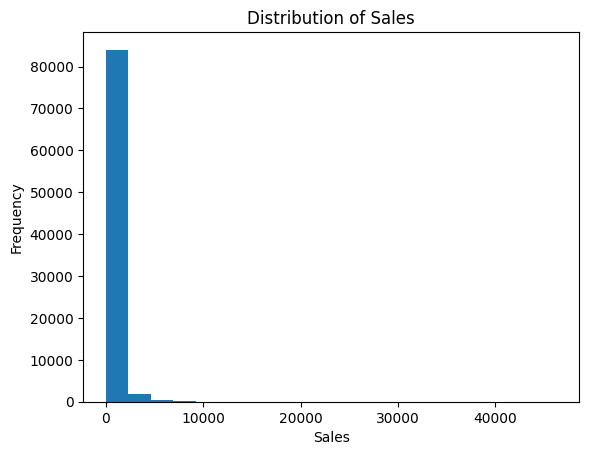

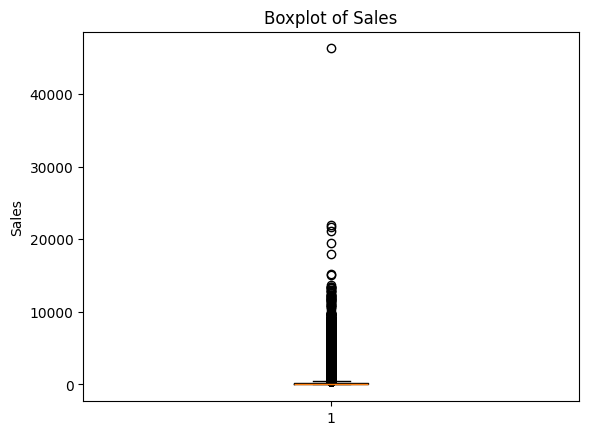

In [235]:
# Histogram
plt.hist(merged_data['sales'], bins=20)
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.title('Distribution of Sales')
plt.show()

# Boxplot
plt.boxplot(merged_data['sales'])
plt.ylabel('Sales')
plt.title('Boxplot of Sales')
plt.show()

The histogram illustrates the distribution of sales values, emphasizing a prominent peak within a specific range. However, the distribution is right-skewed, indicating occasional instances of higher sales values. This skewness suggests that while most sales concentrate around lower values, there are relatively fewer occurrences of very high sales, creating a tail on the right side. The accompanying boxplot reinforces the presence of outliers, noticeable as points beyond the whiskers.

The outliers, representing instances of exceptionally high sales values, hold significance from a business standpoint. These outliers may signify crucial transactions, strategic partnerships, or engagements with key clients. Analyzing and comprehending these high-value sales can provide valuable insights for business decisions, such as targeting similar clients, optimizing marketing strategies, or refining product/service offerings.

#### Distribution of transactions

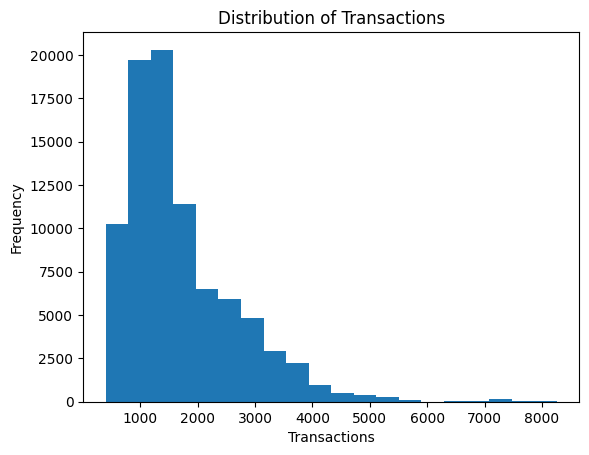

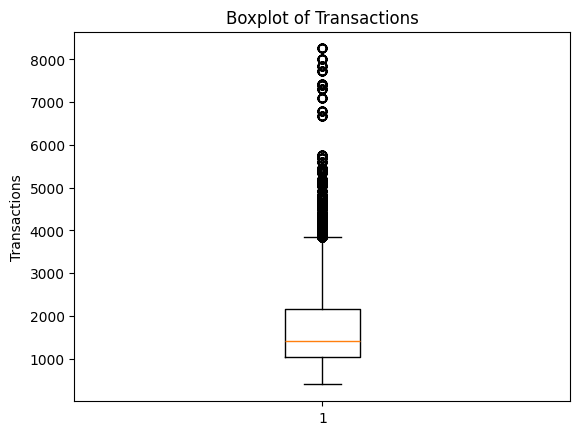

In [236]:
# Histogram
plt.hist(merged_data['transactions'], bins=20)
plt.xlabel('Transactions')
plt.ylabel('Frequency')
plt.title('Distribution of Transactions')
plt.show()

# Boxplot
plt.boxplot(merged_data['transactions'])
plt.ylabel('Transactions')
plt.title('Boxplot of Transactions')
plt.show()

The histogram serves as a tool to understand the distribution of transactions within the dataset. Examining its shape reveals that the bulk of transactions are concentrated within a specific range, evident from the heightened frequency on the left side of the histogram. As the transaction values increase, the frequency gradually diminishes, creating a right-skewed distribution. This pattern suggests that instances of high transaction volumes are relatively infrequent. In summary, the histogram emphasizes the existence of a cluster of transactions with lower frequency, indicating a discernible pattern in the data.







#### Distribution of daily oil prices

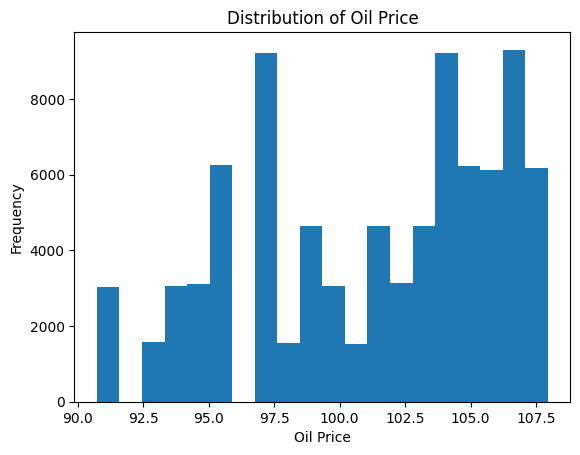

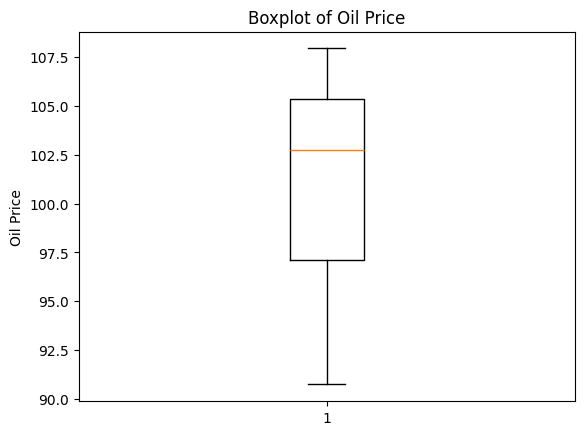

In [237]:
# Histogram
plt.hist(merged_data['dcoilwtico'], bins=20)
plt.xlabel('Oil Price')
plt.ylabel('Frequency')
plt.title('Distribution of Oil Price')
plt.show()

# Boxplot
plt.boxplot(merged_data['dcoilwtico'])
plt.ylabel('Oil Price')
plt.title('Boxplot of Oil Price')
plt.show()

The histogram and boxplot depicting the 'dcoilwtico' variable provide valuable insights into its distribution. The histogram illustrates the frequency distribution of oil prices, showcasing the number of occurrences within each price range. Rather than exhibiting an even distribution, there are discernible clusters or peaks, signifying specific price levels that occur more frequently in the data.







## Bivariate analysis

In [238]:
# Group the data by date and calculate the total sales
daily_sales = merged_data.groupby('date')['sales'].sum().reset_index()

# Create a time series plot with slider
fig = px.line(daily_sales, x='date', y='sales')
fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(title='Trend of Sales Over Time', title_x=0.5)
fig.show()

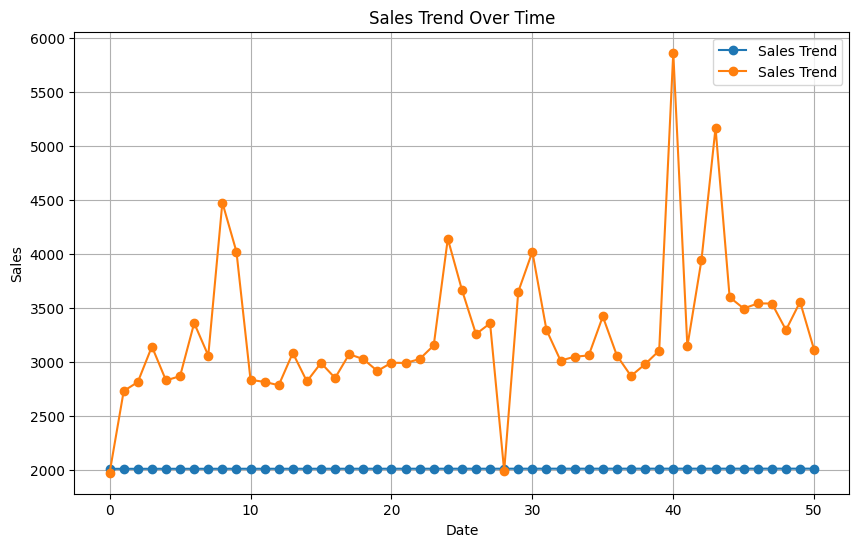

In [239]:
daily_sales = merged_data.groupby('date')['sales'].sum().reset_index()
plt.figure(figsize=(10, 6))
plt.plot(daily_sales, label='Sales Trend', marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Trend Over Time')
plt.grid(True)
plt.legend()
plt.show()

The plot shows the trend of sales over time. From the graph, we can observe that the sales exhibit some variations and fluctuations over time. There are periods of both high and low sales, indicating potential seasonality or other factors affecting sales patterns.

#### Trend of crude oil prices

In [240]:
# Visualizing the 'dcoilwtico' column to confirm if the trend is consistent.
fig = px.line(df_oil, x='date', y='dcoilwtico')
fig.update_layout(title='Trend of Oil Prices Over Time', title_x=0.5, xaxis_title='Date', yaxis_title='Oil Price')
fig.show()

The analysis reveals a notable decline in oil prices towards the end of 2014, with minimal recovery since then. Despite some volatility, oil prices have essentially remained at the same level as they were in the early part of 2015. This raises the possibility of a significant impact on store sales around late 2014. However, upon examining the unit sales data, there is no immediate apparent shift. While there is a drop in sales in the early months of 2015, late 2014 shows an upward trend. Additionally, it is noteworthy that the decline in oil prices does not seem to correlate with changes in sales. As observed from the sales plot, there is no discernible relationship between the drop in oil prices and its impact on sales. Consequently, we can conclude that this feature or data is not of significant importance and will not be considered during the modeling phase.







## Multivariate Analysis

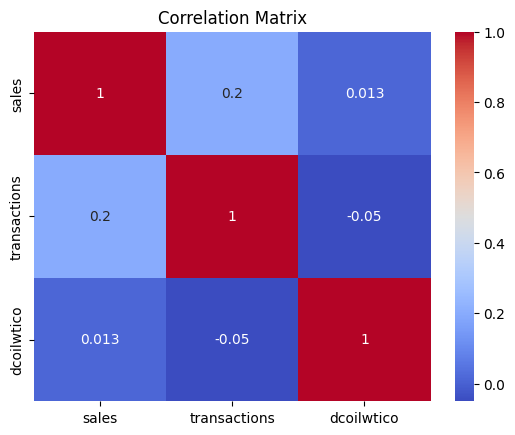

In [241]:
# Select numerical variables for correlation analysis
numerical_vars = ['sales', 'transactions', 'dcoilwtico']
 
# Compute correlation matrix
corr_matrix = merged_data[numerical_vars].corr()
 
# Plot heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

- Sales and Transactions:

There is a weak positive correlation of approximately 0.17 between "Sales" and "Transactions." This suggests that there is a slight positive relationship between the number of transactions and the sales. It implies that when the number of transactions increases, there is a tendency for sales to increase as well, although the correlation is not very strong.

- Sales and Dcoilwito (Oil Prices):

There is a weak negative correlation of approximately -0.031 between "Sales" and "Dcoilwito" (Oil Prices). This indicates a slight negative relationship between sales and oil prices. It suggests that as oil prices increase, there is a tendency for sales to decrease slightly, though the correlation is not significant.

- Transactions and Dcoilwito (Oil Prices):

There is a very weak negative correlation of approximately -0.017 between "Transactions" and "Dcoilwito" (Oil Prices). This suggests that there is almost no relationship between the number of transactions and oil prices. It indicates that fluctuations in oil prices do not have a significant impact on the number of transactions.

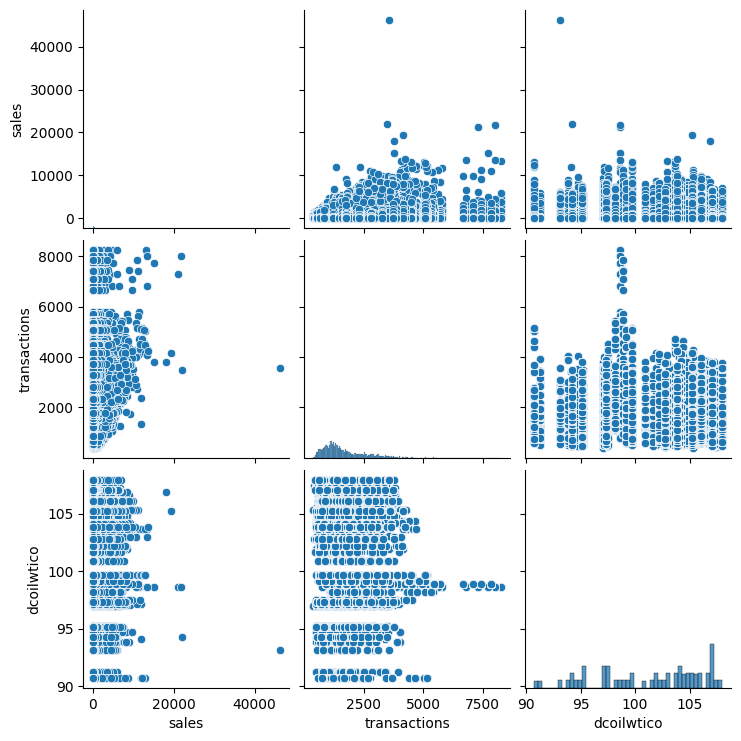

In [242]:
# Select numerical variables for correlation analysis
numerical_vars = ['sales', 'transactions', 'dcoilwtico']
 
# Plot scatter plot matrix
sns.pairplot(merged_data[numerical_vars])
plt.grid(False)

## Stationarity Test

Stationarity implies that the statistical properties of the time series, such as mean and variance, remain constant over time. In this case, the ADF test was conducted on the 'sales' data from the 'merged_data' dataset. To perform the stationarity test, we will use the Augmented Dickey-Fuller (ADF) test commonly used to check for stationarity in a time series.

In [243]:
# # Statistical Test of the 'sales' column in the merged_df using Adfuller
# sales_data = merged_data['sales']

# # Perform ADF test
# result = adfuller(sales_data)

# # Extract the test statistics and p-value from the result
# test_statistic = result[0]
# p_value = result[1]
# critical_values = result[4]

# # Print the test statistics and critical values
# print(f"ADF Test Statistics: {test_statistic}")
# print(f"P-value: {p_value}")
# print("Critical Values:")
# for key, value in critical_values.items():
#     print(f"   {key}: {value}")

# # Check the p-value against a significance level (e.g., 0.05)
# if p_value <= 0.05:
#     print("Reject the null hypothesis: The sales data is stationary.")
# else:
#     print("Fail to reject the null hypothesis: The sales data is non-stationary.")

## Testing the hypothesis

In [244]:
from scipy.stats import ttest_ind

# Assuming 'Sales' is the column representing sales, and 'Promotion' is the binary promotion indicator
sales_no_promotion = merged_data[merged_data['onpromotion'] == 0]['sales']
sales_with_promotion = merged_data[merged_data['onpromotion'] == 1]['sales']

# Perform a t-test
t_stat, p_value = ttest_ind(sales_no_promotion, sales_with_promotion)

# Define significance level (e.g., 0.05)
alpha = 0.05

# Check if the p-value is less than the significance level
if p_value < alpha:
    print("Reject the null hypothesis: Promotions significantly affect sales.")
else:
    print("Fail to reject the null hypothesis: No significant evidence that promotions affect sales.")

Reject the null hypothesis: Promotions significantly affect sales.


## Analytical Questions

#### 1. Is the train data set complete?

In [245]:
# Check the completeness of the train dataset
min_date = merged_data['date'].min()
max_date = merged_data['date'].max()
expected_dates = pd.date_range(start=min_date, end=max_date)
 
missing_dates = expected_dates[~expected_dates.isin(merged_data['date'])]
 
if len(missing_dates) == 0:
    print("The train dataset is complete. It includes all the required dates.")
else:
    print("The train dataset is incomplete. The following dates are missing:")
    print(missing_dates)

The train dataset is incomplete. The following dates are missing:
DatetimeIndex(['2013-01-02', '2013-01-03', '2013-01-04', '2013-01-05',
               '2013-01-06', '2013-01-07', '2013-01-08', '2013-01-09',
               '2013-01-10', '2013-01-11',
               ...
               '2014-07-26', '2014-07-27', '2014-07-28', '2014-07-29',
               '2014-07-30', '2014-07-31', '2014-08-01', '2014-08-02',
               '2014-08-03', '2014-08-04'],
              dtype='datetime64[ns]', length=531, freq=None)


#### 2. Which dates have the lowest and highest sales for each year?

In [246]:
merged_data['date'] = pd.to_datetime(merged_data['date'])
merged_data['year'] = merged_data['date'].dt.year
 
lowest_sales_dates = merged_data.groupby('year')['date'].min()
highest_sales_dates = merged_data.groupby('year')['date'].max()
 
print("Dates with the lowest sales for each year:\n", lowest_sales_dates)
print("="*50)
print("Dates with the highest sales for each year:\n", highest_sales_dates)

Dates with the lowest sales for each year:
 year
2013   2013-01-01
2014   2014-01-01
Name: date, dtype: datetime64[ns]
Dates with the highest sales for each year:
 year
2013   2013-12-31
2014   2014-08-05
Name: date, dtype: datetime64[ns]


#### 3. Are certain groups of stores selling more products? Cluster, City, State ,Type

In [247]:
# Group by cluster and calculate the average sales
average_sales_by_cluster = merged_data.groupby('cluster')['sales'].mean()

# Group by city and calculate the average sales
average_sales_by_city = merged_data.groupby('city')['sales'].mean()

# Group by state and calculate the average sales
average_sales_by_state = merged_data.groupby('state')['sales'].mean()

# Group by store type and calculate the average sales
average_sales_by_store_type = merged_data.groupby('store_type')['sales'].mean()

# Set the number of bars in each plot
num_bars = len(average_sales_by_cluster)

# Generate the colors using the viridis palette
colors = plt.cm.viridis(np.linspace(0, 1, num_bars))

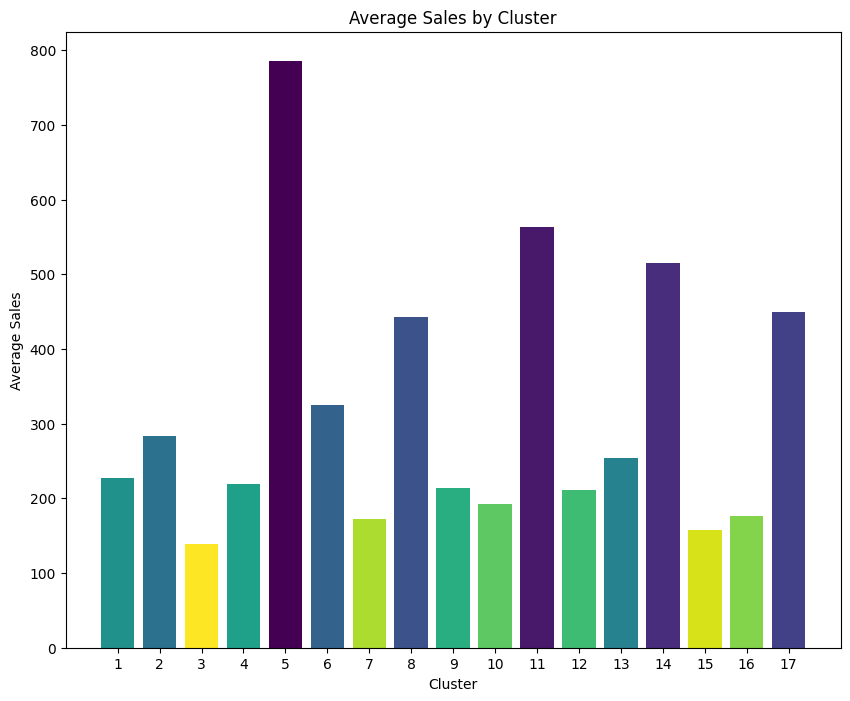

In [248]:
# Sort the data by average sales in descending order
average_sales_by_cluster = average_sales_by_cluster.sort_values(ascending=False)

# Plot the average sales by cluster
plt.figure(figsize=(10, 8))
plt.bar(average_sales_by_cluster.index, average_sales_by_cluster.values, color=colors)
plt.xlabel('Cluster')
plt.ylabel('Average Sales')
plt.title('Average Sales by Cluster')

# Set the x-tick labels as integers
plt.xticks(range(1, len(average_sales_by_cluster.index) + 1))
plt.show()

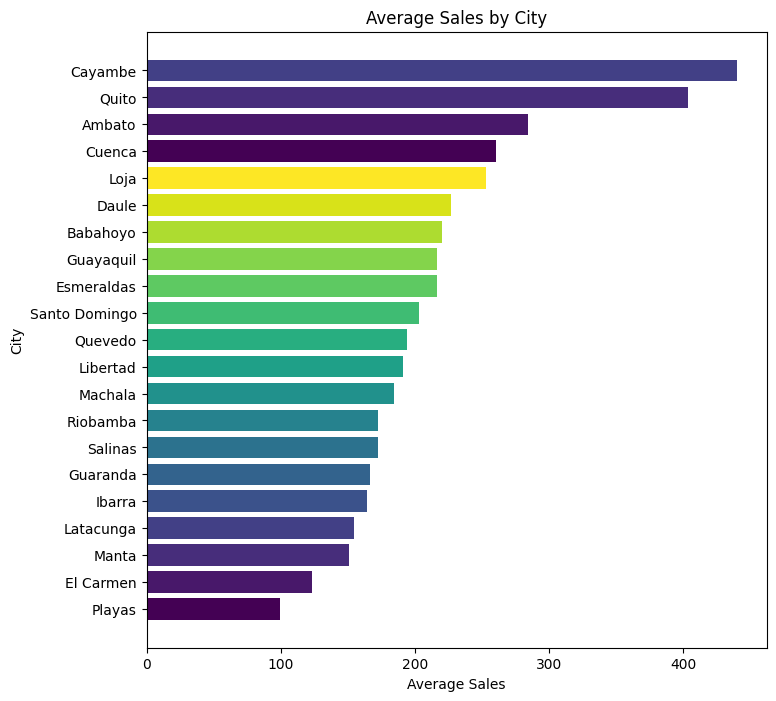

In [249]:
# Sort the data by average sales in descending order
average_sales_by_city = average_sales_by_city.sort_values(ascending=True)

# Plot the average sales by city horizontally
plt.figure(figsize=(8, 8))
plt.barh(average_sales_by_city.index, average_sales_by_city.values, color=colors)
plt.xlabel('Average Sales')
plt.ylabel('City')
plt.title('Average Sales by City')
plt.show()

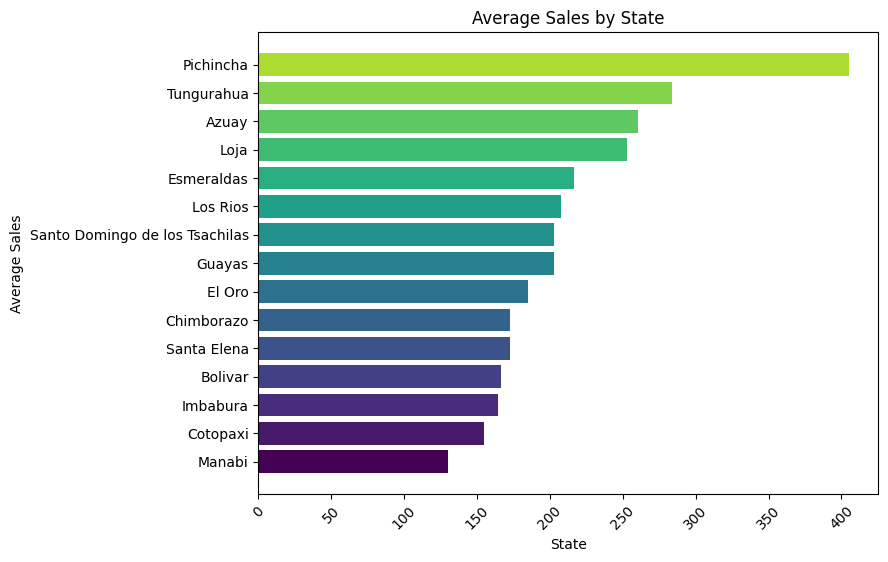

In [250]:
# Sort the data by average sales in descending order
average_sales_by_state = average_sales_by_state.sort_values(ascending=True)

# Plot the average sales by state
plt.figure(figsize=(8, 6))
plt.barh(average_sales_by_state.index, average_sales_by_state.values, color=colors)
plt.xlabel('State')
plt.ylabel('Average Sales')
plt.title('Average Sales by State')
plt.xticks(rotation=45)
plt.show()

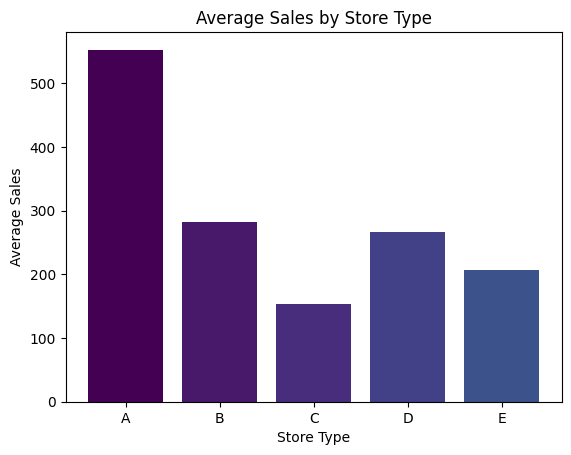

In [251]:
# Plot the average sales by store type
plt.bar(average_sales_by_store_type.index, average_sales_by_store_type.values, color=colors)
plt.xlabel('Store Type')
plt.ylabel('Average Sales')
plt.title('Average Sales by Store Type')
plt.show()

#### 4. Are sales affected by promotions, oil prices and holidays?

In [252]:
# Calculate correlations between sales and promotions, oil prices, holidays
corr_sales_promotions = merged_data['sales'].corr(merged_data['onpromotion'])
corr_sales_oil = merged_data['sales'].corr(merged_data['dcoilwtico'])
corr_sales_holidays = merged_data['sales'].corr(merged_data['holiday_type'] == 'Holiday')

# Print the correlation values
print(f"Correlation between Sales and Promotions: {corr_sales_promotions}")
print(f"Correlation between Sales and Oil Prices: {corr_sales_oil}")
print(f"Correlation between Sales and Holidays: {corr_sales_holidays}")

Correlation between Sales and Promotions: 0.1457052610946709
Correlation between Sales and Oil Prices: 0.012999608633893931
Correlation between Sales and Holidays: -0.028602501937459945


<Axes: xlabel='sales', ylabel='onpromotion'>

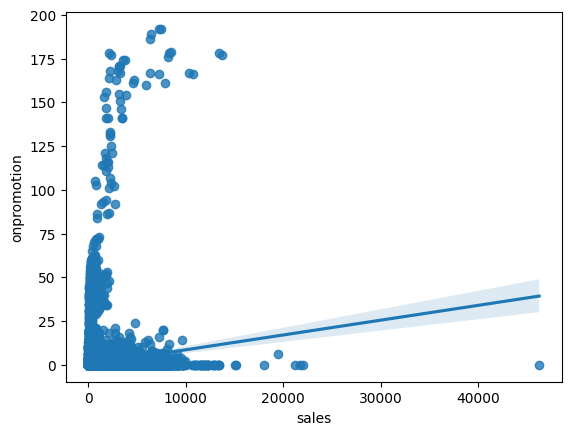

In [253]:
sns.regplot(y='onpromotion',x='sales',data=merged_data)

# Feature Engineering

## Train Dataset

### Extracting Date Components (Day, Month, Year and Day of The Week).

In [254]:
# Extracting Date Components
merged_data['date'] = pd.to_datetime(merged_data['date'])
merged_data['year'] = merged_data['date'].dt.year
merged_data['month'] = merged_data['date'].dt.month
merged_data['day'] = merged_data['date'].dt.day
merged_data.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,transactions,holiday_type,locale,locale_name,description,transferred,dcoilwtico,year,month,day
0,561,2013-01-01,25,AUTOMOTIVE,0.0,0,Salinas,Santa Elena,D,1,770,Holiday,National,Ecuador,Primer dia del ano,False,93.139999,2013,1,1
1,562,2013-01-01,25,BABY CARE,0.0,0,Salinas,Santa Elena,D,1,770,Holiday,National,Ecuador,Primer dia del ano,False,93.139999,2013,1,1
2,563,2013-01-01,25,BEAUTY,2.0,0,Salinas,Santa Elena,D,1,770,Holiday,National,Ecuador,Primer dia del ano,False,93.139999,2013,1,1
3,564,2013-01-01,25,BEVERAGES,810.0,0,Salinas,Santa Elena,D,1,770,Holiday,National,Ecuador,Primer dia del ano,False,93.139999,2013,1,1
4,565,2013-01-01,25,BOOKS,0.0,0,Salinas,Santa Elena,D,1,770,Holiday,National,Ecuador,Primer dia del ano,False,93.139999,2013,1,1


### Dropping Unneccessary Columns in The Merged and Test Datasets as it will not needed for our analysis

In [255]:

columns_to_drop = ['date','id', 'locale', 'locale_name', 'description', 'store_type', 'transferred', 'state']
merged_data = merged_data.drop(columns=columns_to_drop)

merged_data.head()

,store_nbr,family,sales,onpromotion,city,cluster,transactions,holiday_type,dcoilwtico,year,month,day
0,25,AUTOMOTIVE,0.0,0,Salinas,1,770,Holiday,93.139999,2013,1,1
1,25,BABY CARE,0.0,0,Salinas,1,770,Holiday,93.139999,2013,1,1
2,25,BEAUTY,2.0,0,Salinas,1,770,Holiday,93.139999,2013,1,1
3,25,BEVERAGES,810.0,0,Salinas,1,770,Holiday,93.139999,2013,1,1
4,25,BOOKS,0.0,0,Salinas,1,770,Holiday,93.139999,2013,1,1


### Product Categorization Based on Families

In [256]:
unique_families = merged_data['family'].unique()
unique_families

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

In [257]:
# Define the category lists for each product category
food_families = ['BEVERAGES', 'BREAD/BAKERY', 'FROZEN FOODS', 'MEATS', 'PREPARED FOODS', 'DELI','PRODUCE', 'DAIRY','POULTRY','EGGS','SEAFOOD']
home_families = ['HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES']
clothing_families = ['LINGERIE', 'LADYSWARE']
grocery_families = ['GROCERY I', 'GROCERY II']
stationery_families = ['BOOKS', 'MAGAZINES','SCHOOL AND OFFICE SUPPLIES']
cleaning_families = ['HOME CARE', 'BABY CARE','PERSONAL CARE']
hardware_families = ['PLAYERS AND ELECTRONICS','HARDWARE']

# Categorize the 'family' column based on the product categories
merged_data['family'] = np.where(merged_data['family'].isin(food_families), 'FOODS', merged_data['family'])
merged_data['family'] = np.where(merged_data['family'].isin(home_families), 'HOME', merged_data['family'])
merged_data['family'] = np.where(merged_data['family'].isin(clothing_families), 'CLOTHING', merged_data['family'])
merged_data['family'] = np.where(merged_data['family'].isin(grocery_families), 'GROCERY', merged_data['family'])
merged_data['family'] = np.where(merged_data['family'].isin(stationery_families), 'STATIONERY', merged_data['family'])
merged_data['family'] = np.where(merged_data['family'].isin(cleaning_families), 'CLEANING', merged_data['family'])
merged_data['family'] = np.where(merged_data['family'].isin(hardware_families), 'HARDWARE', merged_data['family'])

# Print the updated DataFrame
merged_data.head()

,store_nbr,family,sales,onpromotion,city,cluster,transactions,holiday_type,dcoilwtico,year,month,day
0,25,AUTOMOTIVE,0.0,0,Salinas,1,770,Holiday,93.139999,2013,1,1
1,25,CLEANING,0.0,0,Salinas,1,770,Holiday,93.139999,2013,1,1
2,25,BEAUTY,2.0,0,Salinas,1,770,Holiday,93.139999,2013,1,1
3,25,FOODS,810.0,0,Salinas,1,770,Holiday,93.139999,2013,1,1
4,25,STATIONERY,0.0,0,Salinas,1,770,Holiday,93.139999,2013,1,1


### Feature Scaling

In [258]:
# Scaling Numeric Variables (Min-Max Scaling)
# create an instance of StandardScaler
scaler = StandardScaler()

# select numerical columns
num_cols = ['sales', 'transactions', 'dcoilwtico']

# fit and transform the numerical columns
merged_data[num_cols] = scaler.fit_transform(merged_data[num_cols])

# Display the updated dataframe
merged_data.head()

,store_nbr,family,sales,onpromotion,city,cluster,transactions,holiday_type,dcoilwtico,year,month,day
0,25,AUTOMOTIVE,-0.330040,0,Salinas,1,-0.949878,Holiday,-1.687792,2013,1,1
1,25,CLEANING,-0.330040,0,Salinas,1,-0.949878,Holiday,-1.687792,2013,1,1
2,25,BEAUTY,-0.327684,0,Salinas,1,-0.949878,Holiday,-1.687792,2013,1,1
3,25,FOODS,0.623836,0,Salinas,1,-0.949878,Holiday,-1.687792,2013,1,1
4,25,STATIONERY,-0.330040,0,Salinas,1,-0.949878,Holiday,-1.687792,2013,1,1


Feature scaling is a preprocessing technique used to standardize or normalize the range of independent variables or features of a dataset. The goal of feature scaling is to bring all features to a similar scale, preventing some features from dominating others during the modeling process. This is particularly important for algorithms that are sensitive to the scale of input features.

### Encoding The Categorical Variables

In [259]:
# Define the categorical columns to encode
categorical_columns = ["family", "city", "holiday_type"]

# Perform one-hot encoding
encoder = OneHotEncoder()
encoded_data = encoder.fit_transform(merged_data[categorical_columns])

# Create column names for the one-hot encoded data
column_names = encoder.get_feature_names_out(categorical_columns)

# Convert the one-hot encoded data to a DataFrame
merged_data_encoded = pd.DataFrame(encoded_data.toarray(), columns=column_names)

# Concatenate the original dataframe with the one-hot encoded data
merged_data_encoded = pd.concat([merged_data, merged_data_encoded], axis=1)

# Drop the original categorical columns
merged_data_encoded.drop(categorical_columns, axis=1, inplace=True)

# Print the head of the encoded DataFrame
merged_data_encoded.head()

,store_nbr,sales,onpromotion,cluster,transactions,dcoilwtico,year,month,day,family_AUTOMOTIVE,...,city_Playas,city_Quevedo,city_Quito,city_Riobamba,city_Salinas,city_Santo Domingo,holiday_type_Additional,holiday_type_Event,holiday_type_Holiday,holiday_type_Transfer
0,25,-0.330040,0,1,-0.949878,-1.687792,2013,1,1,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,25,-0.330040,0,1,-0.949878,-1.687792,2013,1,1,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,25,-0.327684,0,1,-0.949878,-1.687792,2013,1,1,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,25,0.623836,0,1,-0.949878,-1.687792,2013,1,1,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,25,-0.330040,0,1,-0.949878,-1.687792,2013,1,1,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


## Test_data

In [260]:
# Extracting Date Components
dt_test['date'] = pd.to_datetime(dt_test['date'])
dt_test['year'] = dt_test['date'].dt.year
dt_test['month'] = dt_test['date'].dt.month
dt_test['day'] = dt_test['date'].dt.day
dt_test.head()

,id,date,store_nbr,family,onpromotion,year,month,day
0,3000888,2017-08-16,1,AUTOMOTIVE,0,2017,8,16
1,3000889,2017-08-16,1,BABY CARE,0,2017,8,16
2,3000890,2017-08-16,1,BEAUTY,2,2017,8,16
3,3000891,2017-08-16,1,BEVERAGES,20,2017,8,16
4,3000892,2017-08-16,1,BOOKS,0,2017,8,16


In [261]:
# Dropping Unnecessary Columns
columns_to_drop = ['date', 'id']
test_data = dt_test.drop(columns=columns_to_drop)
test_data.head()

,store_nbr,family,onpromotion,year,month,day
0,1,AUTOMOTIVE,0,2017,8,16
1,1,BABY CARE,0,2017,8,16
2,1,BEAUTY,2,2017,8,16
3,1,BEVERAGES,20,2017,8,16
4,1,BOOKS,0,2017,8,16


In [262]:
# Product Categorization Based on Families
food_families = ['BEVERAGES', 'BREAD/BAKERY', 'FROZEN FOODS', 'MEATS', 'PREPARED FOODS', 'DELI', 'PRODUCE', 'DAIRY', 'POULTRY', 'EGGS', 'SEAFOOD']
home_families = ['HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES']
clothing_families = ['LINGERIE', 'LADYSWARE']
grocery_families = ['GROCERY I', 'GROCERY II']
stationery_families = ['BOOKS', 'MAGAZINES', 'SCHOOL AND OFFICE SUPPLIES']
cleaning_families = ['HOME CARE', 'BABY CARE', 'PERSONAL CARE']
hardware_families = ['PLAYERS AND ELECTRONICS', 'HARDWARE']

test_data['family'] = np.where(test_data['family'].isin(food_families), 'FOODS', test_data['family'])
test_data['family'] = np.where(test_data['family'].isin(home_families), 'HOME', test_data['family'])
test_data['family'] = np.where(test_data['family'].isin(clothing_families), 'CLOTHING', test_data['family'])
test_data['family'] = np.where(test_data['family'].isin(grocery_families), 'GROCERY', test_data['family'])
test_data['family'] = np.where(test_data['family'].isin(stationery_families), 'STATIONERY', test_data['family'])
test_data['family'] = np.where(test_data['family'].isin(cleaning_families), 'CLEANING', test_data['family'])
test_data['family'] = np.where(test_data['family'].isin(hardware_families), 'HARDWARE', test_data['family'])


In [263]:
# Encoding The Categorical Variables
# List of categorical columns to encode
categorical_columns = ["family"]

# Create an instance of the OneHotEncoder
encoder = OneHotEncoder()

# Perform one-hot encoding on the 'test_data' data for the specified categorical columns
encoded_data = encoder.fit_transform(test_data[categorical_columns])

# Get the column names for the one-hot encoded data
column_names = encoder.get_feature_names_out(categorical_columns)

# Create a DataFrame with the one-hot encoded data and corresponding column names
test_data_encoded = pd.DataFrame(encoded_data.toarray(), columns=column_names)

# Concatenate the original 'test_df' with the one-hot encoded data
test_data_encoded = pd.concat([test_data, test_data_encoded], axis=1)

# Drop the original categorical columns since they have been encoded
test_data_encoded.drop(categorical_columns, axis=1, inplace=True)

# Display the updated 'test_df_encoded' DataFrame
test_data_encoded.head()

,store_nbr,onpromotion,year,month,day,family_AUTOMOTIVE,family_BEAUTY,family_CELEBRATION,family_CLEANING,family_CLOTHING,family_FOODS,family_GROCERY,family_HARDWARE,family_HOME,family_LADIESWEAR,family_LAWN AND GARDEN,"family_LIQUOR,WINE,BEER",family_PET SUPPLIES,family_STATIONERY
0,1,0,2017,8,16,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0,2017,8,16,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,2,2017,8,16,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,20,2017,8,16,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,0,2017,8,16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


# Modeling

### Data Splitting

In [264]:
train_set = merged_data_encoded.loc[merged_data_encoded['year'].isin([2013, 2014, 2015, 2016])]
eval_set = merged_data_encoded.loc[merged_data_encoded['year'] == 2017]

In [265]:
train_set.shape

(86559, 48)

In [266]:
eval_set.shape

(0, 48)

### split data into training and evaluation

In [267]:
# Separate the target variable and features for training and testing
X_train = train_set.drop('sales', axis=1)
y_train = train_set['sales'] 


X_eval = eval_set.drop('sales', axis=1)  
y_eval = eval_set['sales']

In [268]:
# Initialize the results dataframe
results_df = pd.DataFrame(columns=['Model', 'RMSLE', 'RMSE', 'MSE', 'MAE'])

## Model 1. Linear Regression

In [269]:
# Linear Regression Model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_eval)

# Calculate metrics
# Calculate Mean Squared Error (MSE)
lr_mse = mean_squared_error(y_eval, lr_predictions)

# Calculate Mean Absolute Error (MAE)
lr_mae = mean_absolute_error(y_eval, lr_predictions)

# Apply the absolute value function to both y_eval and lr_predictions
y_eval_abs = abs(y_eval)
lr_predictions_abs = abs(lr_predictions)

# Calculate the Root Mean Squared Logarithmic Error (RMSLE)
lr_rmsle = np.sqrt(mean_squared_log_error(y_eval_abs, lr_predictions_abs))

# Create a DataFrame to store results for Linear Regression
results_lr = pd.DataFrame({'Model': ['Linear Regression'],
                            'RMSLE': [lr_rmsle],
                            'RMSE': [np.sqrt(lr_mse)],
                            'MSE': [lr_mse],
                            'MAE': [lr_mae]}).round(2)

# Print the results_lr dataframe
results_lr

ValueError: Found array with 0 sample(s) (shape=(0, 47)) while a minimum of 1 is required by LinearRegression.

In [270]:
X_train

,store_nbr,onpromotion,cluster,transactions,dcoilwtico,year,month,day,family_AUTOMOTIVE,family_BEAUTY,...,city_Playas,city_Quevedo,city_Quito,city_Riobamba,city_Salinas,city_Santo Domingo,holiday_type_Additional,holiday_type_Event,holiday_type_Holiday,holiday_type_Transfer
0,25,0,1,-0.949878,-1.687792,2013,1,1,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,25,0,1,-0.949878,-1.687792,2013,1,1,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,25,0,1,-0.949878,-1.687792,2013,1,1,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,25,0,1,-0.949878,-1.687792,2013,1,1,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,25,0,1,-0.949878,-1.687792,2013,1,1,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86554,9,0,6,0.618614,-0.815432,2014,8,5,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
86555,9,0,6,0.618614,-0.815432,2014,8,5,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
86556,9,0,6,0.618614,-0.815432,2014,8,5,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
86557,9,0,6,0.618614,-0.815432,2014,8,5,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [272]:
X_eval

,store_nbr,onpromotion,cluster,transactions,dcoilwtico,year,month,day,family_AUTOMOTIVE,family_BEAUTY,...,city_Playas,city_Quevedo,city_Quito,city_Riobamba,city_Salinas,city_Santo Domingo,holiday_type_Additional,holiday_type_Event,holiday_type_Holiday,holiday_type_Transfer


## Model 3. Random Forest Regression

In [ ]:
# Random Forest Regression Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_eval)

# Calculate metrics
rf_mse = mean_squared_error(y_eval, rf_predictions)
rf_mae = mean_absolute_error(y_eval, rf_predictions)

# Apply the absolute value function to both y_eval and rf_predictions
y_eval_abs = abs(y_eval)
rf_predictions_abs = abs(rf_predictions)

# Calculate the Root Mean Squared Logarithmic Error (RMSLE)
rf_rmsle = np.sqrt(mean_squared_log_error(y_eval_abs, rf_predictions_abs))

# Create a DataFrame to store results for Random Forest
results_rf = pd.DataFrame({'Model': ['Random Forest'],
                            'RMSLE': [rf_rmsle],
                            'RMSE': [np.sqrt(rf_mse)],
                            'MSE': [rf_mse],
                            'MAE': [rf_mae]}).round(2)

# Print the results_rf dataframe
results_rf

,Model,RMSLE,RMSE,MSE,MAE
0,Random Forest,0.27,0.91,0.83,0.34


RMSLE (Root Mean Squared Logarithmic Error):

Definition: RMSLE is a metric that assesses the ratio between the logarithm of predicted and actual values. It is particularly useful when the target variable exhibits a wide range of values.
Interpretation: A lower RMSLE signifies superior model performance. This metric penalizes underestimation and overestimation equally, making it suitable for skewed distributions where errors in both directions matter.
RMSE (Root Mean Squared Error):

Definition: RMSE is a standard metric that gauges the average magnitude of errors between predicted and actual values. It is calculated as the square root of the mean squared differences.
Interpretation: Similar to RMSLE, a lower RMSE denotes better performance. However, RMSE places more emphasis on larger errors, making it sensitive to outliers and influenced by significant deviations.
MSE (Mean Squared Error):

Definition: MSE represents the mean of the squared differences between predicted and actual values, measuring the average squared deviation of predictions from true values.
Interpretation: Lower MSE values indicate improved model performance. MSE shares the same unit as the squared target variable, facilitating straightforward interpretation.
MAE (Mean Absolute Error):

Definition: MAE is the mean of the absolute differences between predicted and actual values, providing the average magnitude of errors without considering their direction.
Interpretation: Lower MAE values signal better model performance. MAE is less influenced by outliers compared to RMSE, making it a robust choice, particularly when the presence of outliers needs minimal impact on the evaluation.






These results indicate the performance of each model in terms of different metrics. Lower values of RMSLE, RMSE, MSE, and MAE indicate better model performance. Based on these results, the Random Forest appear to perform better than the Linear Regression, ARIMA models in terms of the provided metrics.
